Imports

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If in Colab, we need to pull utilities from github
if IN_COLAB:
  !wget https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/load_model.py
  !wget https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/utils.py
  !wget https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/ImagenetteDataset.py
  !wget https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/AdvExample.py

In [3]:
%pip install -q grad-cam captum

from utils import imshow, imagenette_outputs, multiple_c_o_m, shift, sort_pairs, set_seeds
from ImagenetteDataset import ImagenetteDataset
from load_model import load_model
from AdvExample import AdvExample
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torchvision, torch, torchvision.transforms as T
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm
from scipy.ndimage import center_of_mass
import json

# Captum
from captum.attr import IntegratedGradients, NoiseTunnel, DeepLift, Occlusion
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

Note: you may need to restart the kernel to use updated packages.


Configure Size of Imagenette Pictures and PyTorch Device

In [9]:
imagenette_labels= {
  0: "fish",
  1: "dog",
  2: "cassette player",
  3: "chain saw",
  4: "church",
  5: "French horn",
  6: "garbage truck",
  7: "gas pump",
  8: "golf ball",
  9: "parachute"
}

imagenette_labels_ger = {
    0: "Fisch",
    1: "Hund",
    2: "Kassettenspieler",
    3: "Kettensäge",
    4: "Kirche",
    5: "Horn",
    6: "Müllauto",
    7: "Tankstelle",
    8: "Golfball",
    9: "Fallschirm",
}

# Set seeds for reproducibility
set_seeds(42)

#160 uses ~8GB RAM, 320 uses ~24GB RAM, Fullsize not tested
size = 320
bs = 128
# ScoreCAM seems not to work with mps
# AblationCAM is funky
#cams = [AblationCAM]
cams = [XGradCAM]
#cams = [EigenCAM, EigenGradCAM, XGradCAM, GradCAM, HiResCAM, GradCAMPlusPlus]

if torch.cuda.is_available():
  device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    %env PYTORCH_ENABLE_MPS_FALLBACK=1
else:
  device = "cpu"

print(device)


env: PYTORCH_ENABLE_MPS_FALLBACK=1
mps


Download and unpack images

In [33]:
if size in [160, 320]:
  #Download resized images
  if not os.path.isfile(f'imagenette2-{size}.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-{size}.tgz
    !tar -xf imagenette2-{size}.tgz
elif os.path.isdir(f"imagenette2-{size}"):
    print("Data is present, continuing")
else:
  #Download original images
  print("Downloading originals and resizing")
  if not os.path.isfile(f'imagenette2.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
    !tar -xf imagenette2.tgz
    # Downscale to chosen size
    folder_dir = f"imagenette2-{size}"
    os.rename("imagenette2",folder_dir)
    for dataset in ["train","val"]:
      for classes in os.listdir(f"{folder_dir}/{dataset}"):
        for image in os.listdir(f"{folder_dir}/{dataset}/{classes}"):
          image_path = f"{folder_dir}/{dataset}/{classes}/{image}"
          img = Image.open(image_path)
          img.thumbnail((size,size))
          os.remove(image_path)
          img.save(image_path)



Load Model and target Layers for GradCam

In [5]:
model, target_layers = load_model('mobilenet', norm_layer=True)
model.to(device);
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)


2542856

Build our DataLoaders

In [6]:


trainset = ImagenetteDataset(size, should_normalize=False)
valset = ImagenetteDataset(size, should_normalize=False, validation=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = bs, shuffle = True)
valloader = torch.utils.data.DataLoader(valset, batch_size = bs, shuffle = True)




In [7]:
print(len(trainset))
print(len(valset))

9469
3925


Get first Batch for Testing

In [37]:
data_batch, labels_batch = next(iter(trainloader))
print(data_batch.size())
print(labels_batch.size())
out = torchvision.utils.make_grid(data_batch)

torch.Size([64, 3, 320, 320])
torch.Size([64])


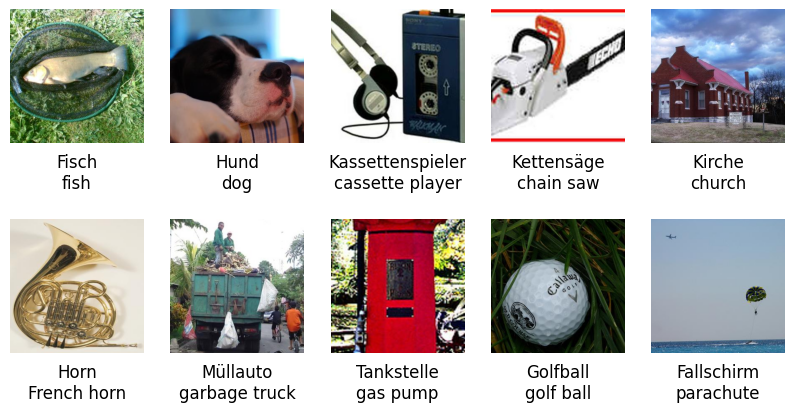

In [42]:
imgs = []
labels=[]
for i in range(10):
  for img, label in zip(data_batch, labels_batch):
    if label.item() == i:
      labels.append(imagenette_labels_ger[label.item()] + "\n" + imagenette_labels[label.item()])
      imgs.append(img.permute(1,2,0).numpy())
      #imshow(img, denorm=False)
      break

# Plot images in a 2x5 grid with labels without axis
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()
for img, lbl, ax in zip(imgs, labels, axs):    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(lbl,y=-0.4)
    
fig.savefig("plots/original_images.png", bbox_inches='tight', dpi=150)



Predict First Batch with our model

In [37]:
model.to(device)
class_names = trainset.classes
print(class_names)
print(data_batch.shape)
outputs = model(data_batch.to(device))
print(outputs.shape)
preds = imagenette_outputs(outputs)
print(labels_batch)
#print(preds)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
torch.Size([4, 3, 320, 320])
torch.Size([4, 1000])
tensor([4, 6, 6, 0])


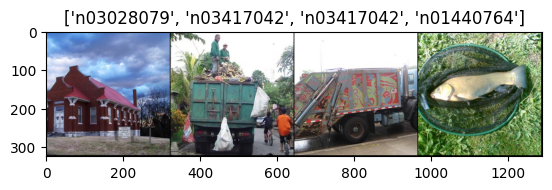

In [11]:

imshow(out, denorm=False, title=[class_names[x] for x in preds])

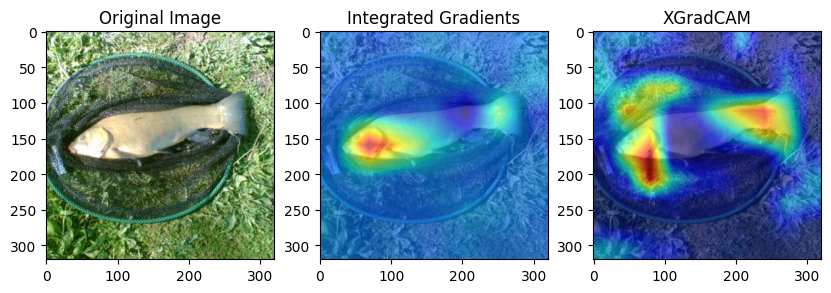

In [49]:
# Plot two heatmaps for XGradCAM and Integrated Gradients
idx = 3
# Get the image and label
image = data_batch[idx].unsqueeze(0).to(device)
#get label
label = labels_batch[idx].unsqueeze(0).to(device)
cam1 = IntegratedGradients(model)
cam2 = XGradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam1.attribute(image, target=label)#, n_steps=50)
#print(f"before transform: {grayscale_cam.shape=}, {type(grayscale_cam)=}")
tograyscale = torchvision.transforms.Grayscale()
grayscale_cam = tograyscale(grayscale_cam)
#grayscale_cam = grayscale_cam.squeeze(0).squeeze().detach().cpu().numpy()
#print(f"after transform: {grayscale_cam.shape=}, {type(grayscale_cam)=}")
#grayscale_cam = cam(input_tensor=data, targets=None)
grayscale_cam = F.interpolate(grayscale_cam, size=(7,7), mode='bilinear', align_corners=False)
grayscale_cam = F.interpolate(grayscale_cam, size=(size,size), mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()

f, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(10,5))
grayscale_cam2 = cam2(input_tensor=image, targets=None)
ax0.imshow(image.squeeze().permute(1,2,0).cpu().numpy())
ax0.title.set_text("Original Image")
ax1.imshow(grayscale_cam, cmap='jet_r')
ax1.imshow(image.squeeze().permute(1,2,0).cpu().numpy(), alpha=0.4)
ax1.title.set_text("Integrated Gradients")
ax2.imshow(grayscale_cam2.squeeze(), cmap='jet')
ax2.imshow(image.squeeze().permute(1,2,0).cpu().numpy(), alpha=0.4)
ax2.title.set_text("XGradCAM",fontsize=20)
plt.savefig("plots/heatmaps.png", bbox_inches='tight', dpi=150)


Run Inference on whole validation set

In [70]:
all_predictions = []
num_correct = 0
with torch.no_grad():
  loop = tqdm(valloader)
  for idx, (data, labels) in enumerate(loop):
    outputs = model(data.to(device))
    preds = imagenette_outputs(outputs)
    all_predictions.extend(preds)
    corrects = torch.sum(preds == labels.to(device))
    num_correct += corrects
    loop.set_description(f"Processing batch {idx+1}")
    loop.set_postfix(current_accuracy = num_correct.float().item()/(len(labels)*(idx+1)))
    #print(f"Done with batch of size {(len(labels))}")
pred = torch.stack(all_predictions)



  0%|          | 0/982 [00:00<?, ?it/s]

Processing batch 982: 100%|██████████| 982/982 [00:20<00:00, 48.70it/s, current_accuracy=1.78] 


In [19]:
num_correct = 0
for data, labels in valloader:
  outputs = model(data.to(device))
  preds = imagenette_outputs(outputs)
  num_correct += torch.sum(preds == labels.to(device))

In [71]:
print("Accuracy: {:.4f}".format(num_correct.float()/len(valset)))

Accuracy: 0.4446


In [ ]:
print(pred.size())
print(pred[0:100])

Generate Adversarial Examples

Experiments to conduct:
- All CAM's, on all images, cutoff 0.99
- All CAM's, on all images, cutoff 0.3
- Best GradCAM (XGradCAM) Variant and IG on all Images 
- final: IG on all images with cutoff

In [10]:

cutoff = 0.99
ignore_third_label = False
allresults = []
experiment_name = "demo_run"

experiment1 = [XGradCAM, EigenCAM, EigenGradCAM, GradCAM, HiResCAM, GradCAMPlusPlus, IntegratedGradients]
experiment2 = [XGradCAM, EigenCAM, EigenGradCAM, GradCAM, HiResCAM]
experiment3 = [XGradCAM, IntegratedGradients]

#cams = [IntegratedGradients]
#cams = []
#Iterate over all cams
for ourcam in [XGradCAM]:
  #Create folder for results
  folder = f"./{experiment_name}adv_examples_{ourcam.__name__}_{size}_{cutoff}/"
  if not os.path.exists(folder):
    os.mkdir(folder)
  
  #Create CAM
  if ourcam == IntegratedGradients:
    cam = ourcam(model)
  else:
    cam = ourcam(model=model, target_layers=target_layers)
  


  # To avoid bias, we only use images which have been used as test set during training
  loop = tqdm(valloader)
  examples = []
  found = 0
  thirdlabel = 0
  same = 0
  invalid = 0
  bad_ex = 0
    
  for batch, (data, labels) in enumerate(loop):

    #break after some time
    #elapsed = loop.format_dict["elapsed"]
    #if elapsed > 240:
    #  break

    # make sure we have at least 2 samples
    if len(data) <= 1:
      break

    #make sure we have even number of samples, if not, remove the last one. Use even block size to avoid this
    if len(labels) % 2 != 0:
      data = data[:-1,:,:,:]
      labels = labels[:-1]
    

    # Sort the batch so that the base and attack image do not have the same label
    # we try it for bs^2 times and then stop, some batches are not sortable in this way
    # we should get almost all of them sorted nicely though
    data, labels = data.to(device), labels.to(device)
    
    #loop.set_description(f"Sorting batch...")
    sort_pairs(data, labels, bs)
    
    # get the CAMs for the batch
    #loop.set_description(f"Calculating CAMs...")
    if ourcam == IntegratedGradients:
      grayscale_cam = cam.attribute(data, target=labels)#, n_steps=50)
    #print(f"before transform: {grayscale_cam.shape=}, {type(grayscale_cam)=}")
      tograyscale = torchvision.transforms.Grayscale()
      grayscale_cam = tograyscale(grayscale_cam)
      #grayscale_cam = grayscale_cam.squeeze(0).squeeze().detach().cpu().numpy()
      #print(f"after transform: {grayscale_cam.shape=}, {type(grayscale_cam)=}")
      #grayscale_cam = cam(input_tensor=data, targets=None)
      grayscale_cam = F.interpolate(grayscale_cam, size=(7,7), mode='bilinear', align_corners=False)
      grayscale_cam = F.interpolate(grayscale_cam, size=(size,size), mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()
    else:
      grayscale_cam = cam(input_tensor=data, targets=None)
    
    cams_base, cams_attack = np.array_split(grayscale_cam, 2, axis=0)
    imgs_base, imgs_attack = np.array_split(data.cpu().numpy(), 2, axis=0)
    labels_base, labels_attack = np.array_split(labels.cpu().numpy(), 2, axis=0)
    #iterate over each batch
    for base_img, attack_img, base_cam, attack_cam, base_label, attack_label in zip(imgs_base, imgs_attack, cams_base, cams_attack, labels_base, labels_attack):
      # ignore pairs with same label (should not happen too often now)
      if (attack_label == base_label):
        same += 1
        continue
      #start with a 99% mask
      current_threshold = cutoff
      
      # Look for the adversarial Example
      while True:
        thresholds = [x[4] for x in examples]
        loop.set_description(f"Found: {found}, 3rdlabel: {thirdlabel} same label: {same}, invalid: {invalid}, bad_ex: {bad_ex}, median threshold: {np.median(thresholds):.2f} using {ourcam.__name__}")
        base_threshold = np.quantile(base_cam.flatten(), current_threshold)
        attack_threshold = np.quantile(attack_cam.flatten(), current_threshold)
        base_mask = np.where(base_cam>base_threshold, np.ones_like(base_cam), np.zeros_like(base_cam))
        attack_mask = np.where(attack_cam>attack_threshold, np.ones_like(attack_cam), np.zeros_like(attack_cam))
        c_o_m_base = np.array(center_of_mass(base_mask))
        c_o_m_attack = np.array(center_of_mass(attack_mask))
        offset = c_o_m_base - c_o_m_attack

        # Remember the last image we produced, in case this is the adversarial example
        if 'invariance_adv' in locals():
          last_img = invariance_adv.copy()

        #Produce the example
        #print(attack_img.shape, offset.shape)
        invariance_adv = np.where(base_mask==True, shift(attack_img, offset), base_img)

        #Check output of Model
        output = imagenette_outputs(model(torch.from_numpy(invariance_adv).unsqueeze(0).to(device)))
        
        if output.item() == base_label:
          # threshold <= 0.01 means we have a mask of 99% -> we can't find an adversarial example
          if current_threshold <= 0.01:
            invalid +=1
            break
          #Model still predicts base label -> make mask bigger
          current_threshold -= 0.01
        else:
          # threshold >= 0.99 means we have a mask of 1% and the model already flips label. We can't find an adversarial example
          if current_threshold >= 0.99:
            invalid +=1
            break
          #model flips early, we look for a better example
          if current_threshold >= cutoff:
            bad_ex += 1
            break
          #We found the example. Write it to disk
          img = Image.fromarray((last_img*255).astype(np.uint8).transpose(1,2,0))
          #Format of image name: base_label_attack_label_intermediate_label_threshold.jpg
          
          if output.item() != attack_label:
            thirdlabel += 1
            if ignore_third_label:
              break
          else:
            found += 1
          Image.fromarray((attack_cam*255).astype(np.uint8)).save(f"{folder}/{base_label}_{attack_label}_{output.item()}_{current_threshold:.2f}_attackcam.jpg")
          Image.fromarray((base_cam*255).astype(np.uint8)).save(f"{folder}/{base_label}_{attack_label}_{output.item()}_{current_threshold:.2f}_basecam.jpg")
          img.save(f"{folder}/{base_label}_{attack_label}_{output.item()}_{current_threshold:.2f}.jpg")
          examples.append((last_img, base_label, attack_label, output.item(), current_threshold))
          break
  thresholds = [x[4] for x in examples]
  filenames = [f"{x[1]}_{x[2]}_{x[3]}_{x[4]:.2f}.jpg" for x in examples]
  results = {
      "found": found,
      "3rdlabel": thirdlabel,
      "same label": same,
      "invalid": invalid,
      "bad": bad_ex,
      "thresholds": list(np.round(thresholds,2)),
      "filenames": filenames,
      "cam": ourcam.__name__,
      "cutoff": cutoff,
      "size": size
    }
  allresults.append(results)
  # write results to json file
  with open(f"{folder}/results.json", "w") as f:
    json.dump(results, f)

  with open(f"{folder}/results.txt", "w") as f:
    f.write(f"Found: {found}, 3rdlabel: {thirdlabel} same label: {same}, invalid: {invalid}, bad: {bad_ex}, median threshold: {np.median(thresholds):.2f} using {ourcam.__name__}, cutoff {cutoff} and {size}x{size} images")
with open(f"./allresults_{size}.json", "w") as f:
  json.dump(allresults, f)
  

  0%|          | 0/62 [00:47<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
axs = axs.flatten()

for result, ax in zip(allresults, axs):    
    ax.hist(result["thresholds"],bins=30, range=[0, cutoff])
    ax.set_title(result["cam"],y=-0.2)


In [25]:
class ExperimentResult():
  def __init__(self, folder):
    try:
      with open(f"{folder}/results.json", "r") as f:
        self.results = json.load(f)
    except:
      self.results = None
      print(f"invalid results in folder: {folder}")
    self.found = self.results["found"]
    self.thirdlabel = self.results["3rdlabel"]
    self.valid = self.found + self.thirdlabel
    self.same = self.results["same label"]
    self.invalid = self.results["invalid"]
    self.bad = self.results["bad"]
    self.thresholds = self.results["thresholds"]
    self.cam = self.results["cam"]
    self.cutoff = self.results["cutoff"]
    self.size = self.results["size"]
    
    self.examples = sorted([AdvExample(f"{folder}/{x}") for x in self.results["filenames"]] , key=lambda x: x.flip_threshold)

  def __str__(self):
    return f"Found: {self.found}, 3rdlabel: {self.thirdlabel} same label: {self.same}, invalid: {self.invalid}, bad: {self.bad}, median threshold: {np.median(self.thresholds):.2f} using {self.cam}, cutoff {self.cutoff} and {self.size}x{self.size} images"
  
  def mean_threshold(self):
    return np.mean(self.thresholds)
  
  def median_threshold(self):
    return np.median(self.thresholds)
  
  def std_threshold(self):
    return np.std(self.thresholds)
  
  def min_threshold(self):
    return np.min(self.thresholds)
  

    

#

Found: 1189, 3rdlabel: 735 same label: 15, invalid: 23, bad: 0, median threshold: 0.52 using IntegratedGradients, cutoff 0.99 and 320x320 images
checking image:  1_6_7_0.67.jpg


IndexError: list index out of range

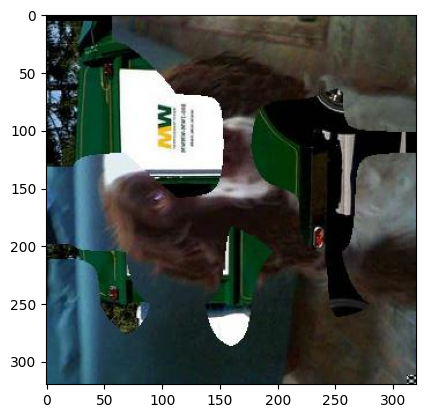

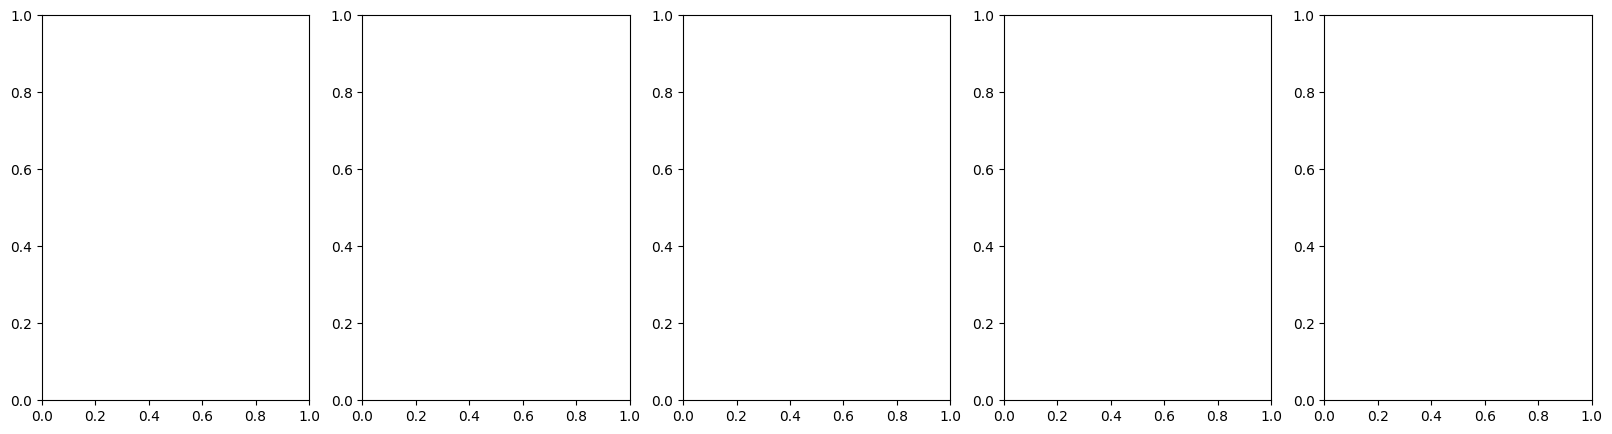

In [66]:
# used in study:
folder = "all_newadv_examples_IntegratedGradients_320_0.99"
# get best
#folder = "best_examplesadv_examples_IntegratedGradients_320_0.2"
best_result = ExperimentResult(folder)
images = []
print(best_result)
for image in os.listdir(folder):
  if image.endswith(".jpg") and "basecam" not in image and "attackcam" not in image:
    print("checking image: ",image)
    image_file = np.array(Image.open(f"{folder}/{image}")).transpose(2,0,1)
    plt.imshow(image_file.transpose(2,1,0))
    image_tensor = torch.from_numpy(image_file).unsqueeze(0).to(device).float().view(1,3,size,size)
    #print(model(image_tensor))
    #print(image_tensor.shape)
    output = imagenette_outputs(model(image_tensor)).item()
    #output = imagenette_outputs(model(torch.from_numpy(image[0]).unsqueeze(0).to(device)))
    label = int(image.split("_")[0])
    print(output, label)
    assert output == label
    # get only examples where final label == atk_label
    #if image.split("_")[1] == image.split("_")[2]:
      #print(image)
    images.append(image)
    #else:
    #  pass
      #print("thirdlabel")
images = sorted(images, key=lambda x: float(x.split("_")[3].split(".jpg")[0]))
f, axs = plt.subplots(1, 5, figsize=(20, 5))
for image in images[:5]:
  #print(image)
  img = Image.open(f"{folder}/{image}")
  axs.flatten()[images.index(image)].imshow(img)
  axs.flatten()[images.index(image)].axis('off')
  axs.flatten()[images.index(image)].set_title(image.split(".jpg")[0],y=-0.15)
plt.show
plt.savefig("plots/best_examples.png", bbox_inches='tight', dpi=150)
print(images[113])

    

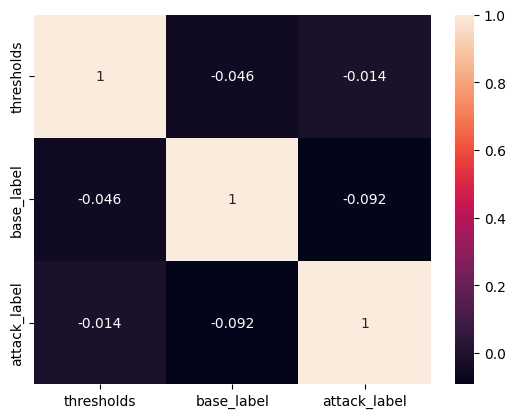

In [27]:
import pandas as pd
import seaborn as sns

df = pd.read_json(f"{folder}/results.json")
df["thresholds_rev"] = 1-df["thresholds"]
df["base_label"] = df["filenames"].apply(lambda x: int(x.split("_")[0]))
df["attack_label"] = df["filenames"].apply(lambda x: int(x.split("_")[1]))
df["final_label"] = df["filenames"].apply(lambda x: int(x.split("_")[2]))
df["same label"] = df["final_label"] == df["attack_label"]
#df.base_label.hist(bins=10)
#print(df.head())

#correlate base label with threshold
df[["base_label", "attack_label", "thresholds"]].corr()
sns.heatmap(df[["thresholds","base_label", "attack_label"]].corr(), annot=True)
plt.savefig("plots/correlation_2.png", bbox_inches='tight', dpi=150)
#df["same_label"].describe()



In [ ]:
#sns.histplot(df, x="thresholds_rev", hue="same_label",bins=10)
#plot with grid
sns.regplot(data=df, x="thresholds_rev", y="same label", logistic=True)
plt.grid()  #just add this
plt.savefig("plots/thresholds_rev.png", bbox_inches='tight', dpi=150)
plt.show()
#sns.histplot(df, x="attack_label", bins=10)

In [ ]:
sns.histplot(df, x="thresholds_rev", hue="same label",bins=10)
plt.xlabel("Threshold")
df[["thresholds_rev", "same label"]].corr()

In [ ]:
import os
myresults = []
for experiment in os.listdir("."):
  if experiment.startswith("all_newadv_examples_"):
  #if experiment.startswith("adv_examples_IntegratedGradients_320_0.99"):
    #print(experiment)
    result = ExperimentResult(experiment)
    if result.cutoff >= 0.99:
      print(result)
      myresults.append(result)
#myresults.append(ExperimentResult("all_newadv_examples_IntegratedGradients_320_0.99"))
#plot all median thresholds with sdt deviation in a single plot
fig, ax = plt.subplots(figsize=(15, 5))
myresults = sorted(myresults, key=lambda x: x.median_threshold())
for result in myresults:
  ax.bar(result.cam, 1-result.median_threshold(), color=(0.2,0.4,0.2,0.6))
plt.savefig("plots/median_thresholds.png", bbox_inches='tight', dpi=150)


In [ ]:
#plot histogram of thresholds in myresults[0]
# get index of myresults where the median threshold is the lowest

idx = np.argmin([x.median_threshold() for x in myresults])
print (myresults[idx])
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(myresults[idx].thresholds, bins=50, range=[0, 1]);

In [ ]:
import shutil

n = 100

#print(len(myresults[0].examples))
os.makedirs(f"best_{n}_{myresults[idx].cam}", exist_ok=True)
best_n = myresults[idx].examples[:n]
for ex in best_n:
  shutil.copyfile(ex.file, f"best_{n}_{myresults[idx].cam}/{ex.file.split('/')[-1]}")
  
os.makedirs(f"random_{n}_{myresults[idx].cam}", exist_ok=True)
#set seed
random.seed(42)
random_n = random.sample(myresults[0].examples, n+1)
for ex in random_n:
  shutil.copyfile(ex.file, f"random_{n}_{myresults[idx].cam}/{ex.file.split('/')[-1]}")
  
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist([i.flip_threshold for i in random_n], bins=50, range=[0, 1]);

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist([i.flip_threshold for i in best_n], bins=50, range=[0, 0.2]);

In [ ]:
from scipy.stats import skew
cutoff = 0.2
for result in allresults:
  #count thresholds < cutoff
  print(f"{result['cam']}: {(len([x for x in result['thresholds'] if x < cutoff])/len(result['thresholds'])):.3f} thresholds < {cutoff}. Skewness: {skew(result['thresholds']):.3f}")

In [ ]:
from torchvision import transforms
convert_tensor = transforms.PILToTensor()
# Check if outputs are correct

for image in examples:

  output = imagenette_outputs(model(torch.from_numpy(image[0]).unsqueeze(0).to(device)))
  # Make sure model predicts base_label for adv_example
  assert output.item() == image[1], f"Wrong output for {image[1]}_{image[2]}: {output[3]} with {image[4]:.2f}"
  
  # Make sure image has correct shape
  assert image[0].shape == (3, size, size), f"Wrong shape for {image[1]}_{image[2]}: {image[0].shape}"
   


TypeError: 'AdvExample' object is not subscriptable

In [ ]:
#get 4 random images from imagenette2-320/train
imgs = []
labels=[]
for i in range(4):
  idx = random.randint(0,len(trainset)-1)
  img, label = trainset[idx]
  
  labels.append(imagenette_labels[label])
  imgs.append(img.permute(1,2,0).numpy())
  #imshow(img, denorm=False)
print(imgs)

#### Results

##### valset 320px 
Found: 135, 3rdlabel: 26 same label: 18, invalid: 109, bad_ex: 1673, cutoff: 0.3,  Median 0.25, best: 0.13. Gradcam Time 38:53

Found: 203, 3rdlabel: 82 same label: 18, invalid: 443, bad_ex: 1215, using EigenCAM: 10:25 0.5\
Found: 148, 3rdlabel: 55 same label: 18, invalid: 328, bad_ex: 1412, using EigenGradCAM: 08:42 0.5\
Found: 634, 3rdlabel: 153 same label: 18, invalid: 89, bad_ex: 1067, using XGradCAM: 05:53 0.5\
Found: 257, 3rdlabel: 114 same label: 18, invalid: 22, bad_ex: 1550, using GradCAM: 03:01 0.5\
Found: 204, 3rdlabel: 117 same label: 18, invalid: 6, bad_ex: 1616, using HiResCAM: 02:34 0.5\
Found: 406, 3rdlabel: 117 same label: 18, invalid: 62, bad_ex: 1358, using GradCAMPlusPlus: 04:16 0.5

Found: 41, 3rdlabel: 8 same label: 18, invalid: 500, bad_ex: 1394, median threshold: 0.25 using EigenCAM: 07:29\
Found: 39, 3rdlabel: 10 same label: 18, invalid: 376, bad_ex: 1518, median threshold: 0.25 using EigenGradCAM: 06:35\
Found: 166, 3rdlabel: 32 same label: 18, invalid: 108, bad_ex: 1637, median threshold: 0.25 using XGradCAM: 02:56\
Found: 61, 3rdlabel: 15 same label: 18, invalid: 31, bad_ex: 1836, median threshold: 0.25 using GradCAM: 02:03\
Found: 37, 3rdlabel: 26 same label: 18, invalid: 6, bad_ex: 1874, median threshold: 0.27 using HiResCAM: 01:48\
Found: 89, 3rdlabel: 25 same label: 18, invalid: 79, bad_ex: 1750, median threshold: 0.26 using GradCAMPlusPlus: 02:33\

Found: 104, 3rdlabel: 39 same label: 18, invalid: 0, bad_ex: 1800, median threshold: 0.26 using XGradCAM with aug_smooth 03:03\
Found: 93, 3rdlabel: 27 same label: 18, invalid: 176, bad_ex: 1647, median threshold: 0.26 using XGradCAM with eigen_smooth 04:51\

Found: 276, 3rdlabel: 62 same label: 16, invalid: 0, bad_ex: 1607, median threshold: 0.24 using IntegratedGradients: 09:09

In [ ]:
examples.sort(key=lambda x: x[4], reverse=False)
#examples.sort(key=lambda x: (x[4]-0.5)**2, reverse=True)
idx = 0
#for idx in range(30):
#  print(f"{examples[idx][4]:.2f}")
print(f"{examples[idx][4]:.2f}, {imagenette_labels[examples[idx][1]]}, {imagenette_labels[examples[idx][2]]}, {imagenette_labels[examples[idx][3]]}")
#plt.imshow(examples[idx][0].transpose(1,2,0))
thresholds = [x[4] for x in examples]
#print median
print(f"Median: {np.median(thresholds):.2f}")
plt.hist(thresholds);


In [ ]:
import AdvExample
myexamples = []
for file in folder:
  if file.endswith(".jpg"):
    myexamples.append(AdvExample(file))

myexamples.sort(key=lambda x: x.threshold, reverse=False)

Export Pictures to disk

In [ ]:
# for idx, img in enumerate(examples):
#   img = Image.fromarray((img*255).astype(np.uint8).transpose(1,2,0))
#   img.save(f"/content/drive/MyDrive/adv_examples_320/{idx}.jpg")

Plot some of the Pictures

In [ ]:

# f, xarr = plt.subplots(2,2, figsize=(15,15))
# xarr.flatten()
# for idx, ax in enumerate(xarr.flatten()):
#   ax.imshow(examples[idx][0].transpose(1,2,0))

1801


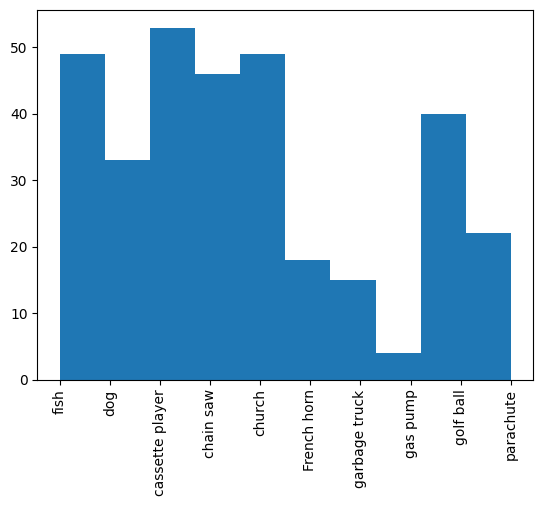

In [55]:
# iterate over images in ./adv_examples_XGradCAM_320_0.99
from AdvExample import AdvExample
import os
experiment = "adv_examples_IntegratedGradients_320_0.99"
examples = []
for file in os.listdir(experiment):
  if file.endswith(".jpg") and not file.endswith("attackcam.jpg") and not file.endswith("basecam.jpg"):
    examples.append(AdvExample(f'{experiment}/{file}'))
print(len(examples))

plt.hist([x.base_label for x in examples if x.flip_threshold < 0.33], bins=10 );
plt.xticks(range(10), [imagenette_labels[x] for x in range(10)], rotation=90);

In [ ]:
# idx = 4
# com_b = c_o_m_base[idx]
# com_a = c_o_m_attack[idx]
# offset = offsets[idx]
# base_image = imgs_base[idx]
# attack_image = imgs_attack[idx]
# print (base_image.shape)
# print (attack_image.shape)
# fig, ax = plt.subplots(1, 2, figsize=(20, 20))
# ax = ax.flatten()
# ax[0].imshow(base_image.transpose(1,2,0))
# ax[0].scatter(com_b[0], com_b[1], s=size, c='C0', marker='+')
# ax[1].imshow(attack_image.transpose(1,2,0))
# ax[1].scatter(com_a[0], com_a[1], s=size, c='C1', marker='+')
# ax[1].scatter(com_b[0], com_b[1], s=size, c='C0', marker='+')


In [ ]:
# print(attack_image.shape)
# shifted = shift(attack_image, offset)
# #print(offset[::-1])
# print (shifted.shape)
# plt.imshow(shifted.transpose(1,2,0))

# # print(com_b, com_a, offset)
# # attack_image_cropped = attack_image[:,39:,11:]
# # #plt.imshow(attack_image_cropped.transpose(1,2,0))
# # print(attack_image_cropped.shape)
# # empty = np.zeros_like(attack_image)
# # empty[:,0:121,0:149] = attack_image_cropped
# # print(empty.shape)



In [ ]:
# invariance_adv = np.where(masks_base[0]==True, shifted, base_image)
# plt.imshow(invariance_adv.transpose(1,2,0))

In [ ]:
# from scipy.ndimage import shift
# print(offsets[11])
# print(masked_base[11].shape)
# print(offsets[0,0])
# print (offsets[:,0])
# one_image = imgs_attack[:,:,offsets[:,0]:,offsets[:,1]:]

# #shifted = shift(masked_base[11], offsets[11], cval=0)
# plt.imshow(attack_patches[4].transpose(1,2,0))
# #plt.imshow(masked_base[11].transpose(1,2,0))

In [ ]:
# print(normalized.shape)
# fig, ax = plt.subplots(2, 4, figsize=(20, 20))
# ax = ax.flatten()
# for i in range(8):
#   idx = random.randint(0, len(masked_images)-1)
#   ax[i].imshow(normalized[idx].transpose(0,1))


In [ ]:
# c_o_m = multiple_c_o_m(masked_images)

# print(c_o_m.shape)
# #c_o_m

In [ ]:
# fig, ax = plt.subplots(2, 4, figsize=(20, 20))
# ax = ax.flatten()
# for i in range(8):
#   idx = random.randint(0, len(masked_images)-1)
#   ax[i].imshow(masked_images[idx].transpose(1,2,0))
#   ax[i].scatter(c_o_m[idx][0], c_o_m[idx][1], s=size, c='C0', marker='+')
#   print(idx, c_o_m[idx])


# plt.show()

In [ ]:
# #not needed
# threshold = np.quantile(gradcam_hm.flatten(), .85)
# b_mask = np.where(gradcam_hm>threshold, np.ones_like(gradcam_hm), np.zeros_like(gradcam_hm))
# print (b_mask.shape)
# img_batch = next(iter(trainloader))[0]
# idx = 4
# plt.imshow((b_mask[idx]*img_batch[idx].detach().cpu().numpy()).transpose(1,2,0))

Explainability with Pytorch Captum

In [ ]:
#%pip install -q git+https://github.com/pytorch/captum.git

from captum.attr import IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

Integrated Gradients

In [ ]:
device = torch.device("mps")
#ig = IntegratedGradients(model)
ig = IntegratedGradients(model)
data, labels = next(iter(trainloader))


In [ ]:
idx = 3
input = data[idx].unsqueeze(0).to(device)
label = labels[idx].to(device)
#print(input.shape)
#print (data[0].size())
#attributions, delta = ig.attribute(input, target=label, n_steps=200, return_convergence_delta=True)
attributions = ig.attribute(input, target=label)

#cam = GradCAM(model=model, target_layers=target_layers, device=torch.device("mps"))
#cam = cam(input_tensor=input, targets=None, eigen_smooth=True)
tograyscale = torchvision.transforms.Grayscale()
attributions = tograyscale(attributions)
print(type(attributions))
#print(type(cam))
print(attributions.shape)
#print(cam.shape)

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)



In [ ]:
cam_size = 7
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(input.squeeze().permute(1,2,0).cpu().numpy())
attributions1 = F.interpolate(attributions, size=(cam_size,cam_size), mode='bilinear', align_corners=False)
attributions2 = F.interpolate(attributions, size=(size,size), mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()
ax[2].imshow(attributions1.squeeze().detach().cpu().numpy(), cmap='gray')
#ax[2].imshow(input.squeeze().permute(1,2,0).cpu().numpy(), alpha=0.8)
ax[1].imshow(attributions2, cmap='gray')

In [ ]:
#res = cv2.resize(np.transpose(attributions, (1,2,0)), dsize=(7, 7), interpolation=cv2.INTER_CUBIC)
import matplotlib.pyplot as plt

# Plot attributions
plt.subplot(1, 2, 1)
plt.imshow(attributions, cmap='gray')
plt.title('Attributions')

# Plot input
plt.subplot(1, 2, 2)
plt.imshow(input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
plt.title('Input')

plt.show()



In [ ]:
import scipy.ndimage as ndimage
ig_smoothed = ndimage.gaussian_filter(attributions, 1, mode='nearest')
plt.imshow(np.transpose(ig_smoothed, (1,2,0)), cmap='gray')

In [ ]:
imshow(data[idx], denorm=False)

Noise Tunnel for Smooting

In [ ]:
# nt_samples <= 7 for 15GB VRAM 
noise_tunnel = NoiseTunnel(ig)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=4, nt_type='smoothgrad_sq', target=label)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(data[idx].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
#plt.imshow(show_cam_on_image(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                      np.transpose(data[idx].squeeze().cpu().detach().numpy(), (1,2,0)), use_rgb=True))